# Carl Zeiss Summerschool - 2D Inference

## Imports

In [2]:
import nifty8 as ift
import numpy as np
import matplotlib.pyplot as plt

ift.random.push_sseq_from_seed(43)

def plot2D(arr, title=""):
    plt.imshow(arr, origin="lower")
    plt.title(f"{title}")
    plt.colorbar()

## Load data

In [3]:
# load data
data_raw = np.load("data/2D_data.npy")

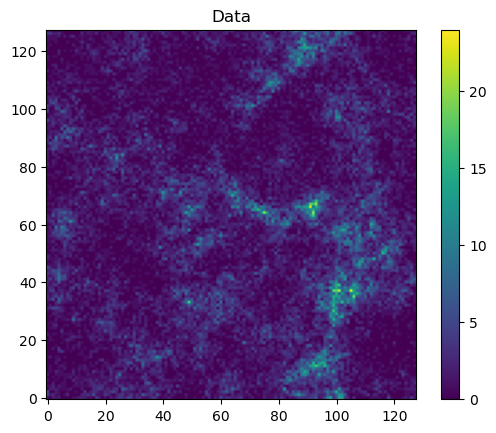

In [4]:
# plot data
plot2D(data_raw, "Data")

# Set up Space

In [ ]:
# set up RGSPace [128, 128]

In [ ]:
# print space

# Set up generative process for a correlated structures

In [ ]:
# ift.SimpleCorrelatedField?

In [ ]:
# kwargs for the SimpleCorrelatedField
args = {
    'offset_mean': 0.3,
    'offset_std': (1e-3, 1e-6),

    # Amplitude of field fluctuations
    'fluctuations': (1.0, 0.8),  # 1.0, 1e-2

    # Exponent of power law power spectrum component
    'loglogavgslope': (-3.3, 1),  # -6.0, 1

    # Amplitude of integrated Wiener process power spectrum component
    'flexibility': (0.5, 0.2),  # 1.0, 0.5

    # How ragged the integrated Wiener process component is
    'asperity': (0.01, 0.005)  # 0.1, 0.5
}

#### A bit simplified
$$ \mathrm{correlated field} = HT( A * z * \xi ) + o $$

$A$: Amplitude Operator  
$z$: zeromode  
$\xi$: Exitations  
$o$: Offset

In [ ]:
# Initialize a lognormal correlated field
correlated_field = ift.SimpleCorrelatedField(sp, **args)
sky = ift.exp(correlated_field)

In [ ]:
# get power_spectrum operator from correlated field
pspec = correlated_field.power_spectrum

In [ ]:
# print some OpChains

# Look at Prior Samples

In [ ]:
# Draw random numbers on domain correlated_field.domain /val [xi_prior]

In [ ]:
# plot xis / power spectrum and prior sample of sky 
xies = xi_prior["xi"].val
plot2D(xies, "xi")

In [ ]:
# Apply correlated_field Operator and power spectrum operator
prior_sample = sky(xi_prior)
prior_spectrum = pspec.force(xi_prior)

In [ ]:
# plot prior power spectrum
plt.plot(prior_spectrum.val)
plt.title("pspec")
plt.loglog()

In [ ]:
# show prior_sample
plot2D(prior_sample.val, "sky")

# Data to a field

In [ ]:
# Data into Field and show
data = ift.makeField(sp, data_raw)
print(data)

# The Bayesian Part
$$ \mathcal{P}(s|d) \propto \mathcal{P}(d|s)\mathcal{P}(s)$$
$$ \mathcal{H}(s|d)\quad \widehat{=} \quad \mathcal{H}(d|s) \quad + \quad \mathcal{H}(s)$$

$$\mathcal{H}(d|s) = - \log (\mathrm{Poisson})(d|s) = \sum s - d^\dagger \log(s)$$

In [ ]:
# Build a poissonian log likelihood from data and sky

# IterationController and Minimizer

In [ ]:
ic_sampling = ift.AbsDeltaEnergyController(deltaE=0.05, iteration_limit=100)
ic_sampling_nl = ift.AbsDeltaEnergyController(deltaE=0.05, iteration_limit=10)
ic_newton = ift.AbsDeltaEnergyController(name='Optimizer', deltaE=0.5, convergence_level=2, iteration_limit=5)

minimizer = ift.NewtonCG(ic_newton)
minimizer_sampling = (lambda iiter: None if iiter < 3 else ift.NewtonCG(ic_sampling_nl))

# Optimize KL
Perform Inferece:
- Maximum a posteriori
- Metric Gaussian Variational Inference
- Geometric Variational Inference

In [ ]:
n_iterations = 5
n_samples = 5

samples = ift.optimize_kl(log_likelihood, n_iterations, n_samples, minimizer, ic_sampling, minimizer_sampling)

# Minisanity & Posterior Analysis

In [ ]:
# What is minisanity?
# Calc posterior mean / posterior std from samples 

In [ ]:
# Plot posterior mean

In [ ]:
# load "data/2D_GT.npy" and plot Ground truth 
truth = np.load("data/2D_GT.npy")
plot2D(truth)

In [ ]:
# Posterior Sky Sample List
sample_list_sky = list(samples.iterator(sky))

In [ ]:
# Plot Sample 4
plot2D(sample_list_sky[4].val)

In [ ]:
# Posterior Sample List Pspec
sample_list_pspec = list(samples.iterator(pspec))

In [ ]:
# load true pspec from "data/pspec.npy"
gt_spec = np.load("data/pspec.npy")

In [ ]:
# plot posterior power spectrum / gt pspec / prior
plt.plot(gt_spec, label="Ground Truth")
plt.plot(prior_spectrum.val, label="prior spec sample")
for i in range(10):
    plt.plot(sample_list_pspec[i].val)
plt.legend()
plt.title("pspec")
plt.loglog()

# More realistic Example - Detector Mask / Exposure

In [5]:
# Load Data and Exposure and put into fields
detector_data = np.load("data/2D_detector_data.npy")
detector_exposure = np.load("data/2D_detector_exposure.npy")

detector_data_field = ift.makeField(sp, detector_data)
detector_exp_field = ift.makeField(sp, detector_exposure)

NameError: name 'sp' is not defined

In [ ]:
#plot detector_data and exposure
plot2D(detector_data)

In [ ]:
plot2D(detector_exposure)

In [ ]:
# detector_exp_field to detector_exp_op
detector_exp_op = ift.makeOp(detector_exp_field)

In [ ]:
# Build Boolean Mask for the detector
detector_flags = np.ones(detector_exp_field.shape)
detector_flags[detector_exposure!=0] = 0
mask = ift.MaskOperator(ift.makeField(sp,detector_flags))

In [ ]:
# plot detector_flags
plot2D(detector_flags)

In [ ]:
# Build your Signal Response
signal_response = mask @ detector_exp_op @ sky

In [ ]:
# Remove flagged data points
masked_data = mask(detector_data_field)

In [ ]:
# Set up new Likelihood
log_likelihood_detector = ift.PoissonianEnergy(masked_data)@signal_response

In [ ]:
# Optimize Kl
samples_detector = ift.optimize_kl(log_likelihood_detector, n_iterations, n_samples, minimizer, ic_sampling, minimizer_sampling)

In [ ]:
pmean, pvar = samples_detector.sample_stat(sky)

In [ ]:
pstd = pvar.sqrt()

In [ ]:
plot2D(pmean.val)

In [ ]:
plot2D(pstd.val/pmean.val)#vmin vmax

In [ ]:
sky_samples = list(samples_detector.iterator(sky))

In [ ]:
plot2D(sky_samples[4].val)

In [ ]:
plot2D(truth)

In [ ]:
sr_mean, _ = samples_detector.sample_stat(signal_response)

In [ ]:
NWR = mask.adjoint((sr_mean - masked_data)/ sr_mean.sqrt())

In [ ]:
plot2D(NWR.val)